**튜닝 가능한 것**
- PCA: `n_components`, `kernelPCA`
- 판매단가 scaling 방법
- batchnormalization, dropout, CIN?? -> documentation 참고


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install deepctr[gpu]

     |████████████████████████████████| 112kB 9.5MB/s 
     |████████████████████████████████| 320.4MB 23kB/s 


In [4]:
!pip install deepctr

In [14]:
# 모듈 불러오기
import os

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import KernelPCA, PCA

# from deepctr.models import DeepFM
from deepctr.models.xdeepfm import xDeepFM
from deepctr.feature_column import SparseFeat, DenseFeat, get_feature_names


import tensorflow.keras.backend as K
from tensorflow.keras import optimizers

import matplotlib.pyplot as plt

In [6]:
# 경로 설정
import os
os.chdir("/content/drive/My Drive/Big-Contest")

In [7]:
# 데이터 로드
# data = pd.read_csv("./data/범주데이터모음.csv", usecols=lambda x: 'Unnamed' not in x)
# data = pd.read_csv("/content/drive/Shared drives/빅콘테스트/데이터(전처리 후 논의 대상)/범주데이터모음2.csv", 
#                    usecols=lambda x: 'Unnamed' not in x)
# data2 = pd.read_csv("/content/drive/Shared drives/빅콘테스트/데이터(전처리 후 논의 대상)/deepfm데이터.csv",
#                     usecols=lambda x: 'Unnamed' not in x)
data = pd.read_csv("./data/input(csv).csv", usecols=lambda x:'Unnamed' not in x)
data

,AMT,day_map,hour_map,month_map,gender_map,productname_map,brand_map,season_map,exposure_map,warning3_map,warning4_map,iswarning_map,iswarning2_map,dailyrain_map,dailysnow_map,dailytmpmean_map,dailytmpmax_map,dailytmpmin_map,dailytmpmean2_map,dailytmpmax2_map,dailytmpmin2_map,dailytmpdis_map,dailyhumidmean_map,dailyhumidmean2_map,dailyhumidmax2_map,dailysunshine_map,productprice,sangdo4_man_20after,doksan3_man_20after,myeonmok4_man_30,doksan3_man_20,sangdo4_woman_30before,bukgajwa2_man_30before,whagok1_man_20after,ungam1_man_30before,yaksoo_30,ungam1_man_30after,sangdo4_all,whagok1_30,wangsipri_man_40after,...,gaebong1_40,sangdo4_woman_20after,sangdo2_40,junggyebon_40,donam2_man_30after,junggyebon_man_30after,bukgajwa2_30,hangdang2_man_40before,whagokbon_man_40after,namgajwa1_man_40after,amsa2_man_30after,oryu2_man_30after,gilrum1_man_40before,sangdo4_20,donam2_man_40before,oryu1_20,girum1_40,wangsipri2_man_20after,deungchon2_man_20after,wangsipri2_man_30after,deungchon2_man_30after,bulgwang1_man_40before,sangdo4_man_30after,bulgwang1_woman_20after,whagokbon_man_30before,sangdo2_30,myeonmok2_20,oryu1_woman_20after,girum1_man_30after,sinwon_man_30before,hangdang2_man_50before,whagokbon_man_20after,sangdo4_man_30before,sadang3_man_30before,sindorim_man_30after,samgaksan_man_40before,sangdo4_man_40before,sanggye9_man_40before,chungrim_40,bulgwang1_woman_40before
0,12033000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39900,21157.9652,23210.4128,79614.4645,43264.4012,25209.80,29323.9143,51669.9557,17360.3516,63151.9828,23107.0476,594448.947,241138.3858,12547.0516,...,113370.8866,19983.8514,90802.3558,113994.4432,11186.9930,9805.4051,139261.3605,19888.4714,29942.4217,16802.0284,20553.3294,50881.6036,37731.2518,41141.8166,12113.7308,36318.5028,163440.1071,10859.0887,15892.0932,16160.7448,20643.8627,33823.0684,24992.2484,28271.9505,36269.4135,106505.2131,35929.0792,17689.9975,31028.9739,25403.8632,16925.0186,31064.5874,23463.5336,19184.1445,43370.1885,25919.2102,23052.6533,15691.2019,37864.1904,34724.3132
1,20663000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39900,21157.9652,23210.4128,79614.4645,43264.4012,25209.80,29323.9143,51669.9557,17360.3516,63151.9828,23107.0476,594448.947,241138.3858,12547.0516,...,113370.8866,19983.8514,90802.3558,113994.4432,11186.9930,9805.4051,139261.3605,19888.4714,29942.4217,16802.0284,20553.3294,50881.6036,37731.2518,41141.8166,12113.7308,36318.5028,163440.1071,10859.0887,15892.0932,16160.7448,20643.8627,33823.0684,24992.2484,28271.9505,36269.4135,106505.2131,35929.0792,17689.9975,31028.9739,25403.8632,16925.0186,31064.5874,23463.5336,19184.1445,43370.1885,25919.2102,23052.6533,15691.2019,37864.1904,34724.3132
2,47878000,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,59000,21157.9652,23210.4128,79614.4645,43264.4012,25209.80,29323.9143,51669.9557,17360.3516,63151.9828,23107.0476,594448.947,241138.3858,12547.0516,...,113370.8866,19983.8514,90802.3558,113994.4432,11186.9930,9805.4051,139261.3605,19888.4714,29942.4217,16802.0284,20553.3294,50881.6036,37731.2518,41141.8166,12113.7308,36318.5028,163440.1071,10859.0887,15892.0932,16160.7448,20643.8627,33823.0684,24992.2484,28271.9505,36269.4135,106505.2131,35929.0792,17689.9975,31028.9739,25403.8632,16925.0186,31064.5874,23463.5336,19184.1445,43370.1885,25919.2102,23052.6533,15691.2019,37864.1904,34724.3132
3,99736000,0,2,0,0,2,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,59900,21157.9652,23210.4128,79614.4645,43264.4012,25209.80,29323.9143,51669.9557,17360.3516,63151.9828,23107.0476,594448.947,241138.3858,12547.0516,...,113370.8866,19983.8514,90802.3558,113994.4432,11186.9930,9805.4051,139261.3605,19888.4714,29942.4217,16802.0284,20553.3294,50881.6036,37731.2518,41141.8166,12113.7308,36318.5028,163440.1071,10859.0887,15892.0932,16160.7448,20643.8627,33823.0684,24992.2484,28271.9505,36269.4135,106505.2131,35929.0792,17689.9975,31028.9739,25403.8632,16925.0186,31064.5874,23463.5336,19184.1445,43370.1885,25919.2102,23052.6533,15691.2019,37864.1904,3

# 컬럼

In [10]:
# 컬럼 확인
len(data.columns), data.columns

(177, Index(['AMT', 'day_map', 'hour_map', 'month_map', 'gender_map',
        'productname_map', 'brand_map', 'season_map', 'exposure_map',
        'warning3_map',
        ...
        'hangdang2_man_50before', 'whagokbon_man_20after',
        'sangdo4_man_30before', 'sadang3_man_30before', 'sindorim_man_30after',
        'samgaksan_man_40before', 'sangdo4_man_40before',
        'sanggye9_man_40before', 'chungrim_40', 'bulgwang1_woman_40before'],
       dtype='object', length=177))

## 유동인구 컬럼 차원축소

In [33]:
# 유동인구 컬럼
population_columns = [x for x in data.columns if 'map' not in x and x not in ['AMT', 'productprice']]
population_df = data[population_columns]
population_df

,sangdo4_man_20after,doksan3_man_20after,myeonmok4_man_30,doksan3_man_20,sangdo4_woman_30before,bukgajwa2_man_30before,whagok1_man_20after,ungam1_man_30before,yaksoo_30,ungam1_man_30after,sangdo4_all,whagok1_30,wangsipri_man_40after,sangdo4_30,chungryong_man_20after,goduk1_man_30after,myeonmok4_man_30after,whagok1_man_30before,wangsipri2_man_30before,singjung7_40,daejo_woman_20after,ungam2_30,jungang_man_30before,mok2_man_40before,mia_20,oryu1_man_30before,gumho23_man_30after,sinwon_woman_30before,gaebong1_man_30before,sangdo2_man_30before,mok5_man_50before,dapsipri1_woman_20after,wahgokbon_woman_20after,ungam2_man_30after,gaebong1_man_40before,sangdo2_man_40before,chungrim_woman_30before,songcheon_20,gaebong1_20,singjung3_man_30before,...,gaebong1_40,sangdo4_woman_20after,sangdo2_40,junggyebon_40,donam2_man_30after,junggyebon_man_30after,bukgajwa2_30,hangdang2_man_40before,whagokbon_man_40after,namgajwa1_man_40after,amsa2_man_30after,oryu2_man_30after,gilrum1_man_40before,sangdo4_20,donam2_man_40before,oryu1_20,girum1_40,wangsipri2_man_20after,deungchon2_man_20after,wangsipri2_man_30after,deungchon2_man_30after,bulgwang1_man_40before,sangdo4_man_30after,bulgwang1_woman_20after,whagokbon_man_30before,sangdo2_30,myeonmok2_20,oryu1_woman_20after,girum1_man_30after,sinwon_man_30before,hangdang2_man_50before,whagokbon_man_20after,sangdo4_man_30before,sadang3_man_30before,sindorim_man_30after,samgaksan_man_40before,sangdo4_man_40before,sanggye9_man_40before,chungrim_40,bulgwang1_woman_40before
0,21157.9652,23210.4128,79614.4645,43264.4012,25209.80,29323.9143,51669.9557,17360.3516,63151.9828,23107.0476,594448.947,241138.3858,12547.0516,97791.8744,73868.9298,14298.0405,22993.1293,59459.9521,13482.1272,108081.8727,37144.935,71678.0913,24715.2804,23176.9355,42336.5016,19232.2343,30235.0776,20064.3504,23100.2084,25802.3193,42602.4415,21269.0192,32964.5196,21604.1638,28614.4228,25104.4471,9136.9559,42448.6660,42892.4173,26131.9401,...,113370.8866,19983.8514,90802.3558,113994.4432,11186.9930,9805.4051,139261.3605,19888.4714,29942.4217,16802.0284,20553.3294,50881.6036,37731.2518,41141.8166,12113.7308,36318.5028,163440.1071,10859.0887,15892.0932,16160.7448,20643.8627,33823.0684,24992.2484,28271.9505,36269.4135,106505.2131,35929.0792,17689.9975,31028.9739,25403.8632,16925.0186,31064.5874,23463.5336,19184.1445,43370.1885,25919.2102,23052.6533,15691.2019,37864.1904,34724.3132
1,21157.9652,23210.4128,79614.4645,43264.4012,25209.80,29323.9143,51669.9557,17360.3516,63151.9828,23107.0476,594448.947,241138.3858,12547.0516,97791.8744,73868.9298,14298.0405,22993.1293,59459.9521,13482.1272,108081.8727,37144.935,71678.0913,24715.2804,23176.9355,42336.5016,19232.2343,30235.0776,20064.3504,23100.2084,25802.3193,42602.4415,21269.0192,32964.5196,21604.1638,28614.4228,25104.4471,9136.9559,42448.6660,42892.4173,26131.9401,...,113370.8866,19983.8514,90802.3558,113994.4432,11186.9930,9805.4051,139261.3605,19888.4714,29942.4217,16802.0284,20553.3294,50881.6036,37731.2518,41141.8166,12113.7308,36318.5028,163440.1071,10859.0887,15892.0932,16160.7448,20643.8627,33823.0684,24992.2484,28271.9505,36269.4135,106505.2131,35929.0792,17689.9975,31028.9739,25403.8632,16925.0186,31064.5874,23463.5336,19184.1445,43370.1885,25919.2102,23052.6533,15691.2019,37864.1904,34724.3132
2,21157.9652,23210.4128,79614.4645,43264.4012,25209.80,29323.9143,51669.9557,17360.3516,63151.9828,23107.0476,594448.947,241138.3858,12547.0516,97791.8744,73868.9298,14298.0405,22993.1293,59459.9521,13482.1272,108081.8727,37144.935,71678.0913,24715.2804,23176.9355,42336.5016,19232.2343,30235.0776,20064.3504,23100.2084,25802.3193,42602.4415,21269.0192,32964.5196,21604.1638,28614.4228,25104.4471,9136.9559,42448.6660,42892.4173,26131.9401,...,113370.8866,19983.8514,90802.3558,113994.4432,11186.9930,9805.4051,139261.3605,19888.4714,29942.4217,16802.0284,20553.3294,50881.6036,37731.2518,41141.8166,12113.7308,36318.5028,163440.1071,10859.0887,15892.0932,16160.7448,20643.8627,33823.0684,24992.2484,28271.9505

In [38]:
# 결측치 채우기
population_df[population_df.isnull()]
population_df=population_df.fillna(value=0)
population_df

,sangdo4_man_20after,doksan3_man_20after,myeonmok4_man_30,doksan3_man_20,sangdo4_woman_30before,bukgajwa2_man_30before,whagok1_man_20after,ungam1_man_30before,yaksoo_30,ungam1_man_30after,sangdo4_all,whagok1_30,wangsipri_man_40after,sangdo4_30,chungryong_man_20after,goduk1_man_30after,myeonmok4_man_30after,whagok1_man_30before,wangsipri2_man_30before,singjung7_40,daejo_woman_20after,ungam2_30,jungang_man_30before,mok2_man_40before,mia_20,oryu1_man_30before,gumho23_man_30after,sinwon_woman_30before,gaebong1_man_30before,sangdo2_man_30before,mok5_man_50before,dapsipri1_woman_20after,wahgokbon_woman_20after,ungam2_man_30after,gaebong1_man_40before,sangdo2_man_40before,chungrim_woman_30before,songcheon_20,gaebong1_20,singjung3_man_30before,...,gaebong1_40,sangdo4_woman_20after,sangdo2_40,junggyebon_40,donam2_man_30after,junggyebon_man_30after,bukgajwa2_30,hangdang2_man_40before,whagokbon_man_40after,namgajwa1_man_40after,amsa2_man_30after,oryu2_man_30after,gilrum1_man_40before,sangdo4_20,donam2_man_40before,oryu1_20,girum1_40,wangsipri2_man_20after,deungchon2_man_20after,wangsipri2_man_30after,deungchon2_man_30after,bulgwang1_man_40before,sangdo4_man_30after,bulgwang1_woman_20after,whagokbon_man_30before,sangdo2_30,myeonmok2_20,oryu1_woman_20after,girum1_man_30after,sinwon_man_30before,hangdang2_man_50before,whagokbon_man_20after,sangdo4_man_30before,sadang3_man_30before,sindorim_man_30after,samgaksan_man_40before,sangdo4_man_40before,sanggye9_man_40before,chungrim_40,bulgwang1_woman_40before
0,21157.9652,23210.4128,79614.4645,43264.4012,25209.80,29323.9143,51669.9557,17360.3516,63151.9828,23107.0476,594448.947,241138.3858,12547.0516,97791.8744,73868.9298,14298.0405,22993.1293,59459.9521,13482.1272,108081.8727,37144.935,71678.0913,24715.2804,23176.9355,42336.5016,19232.2343,30235.0776,20064.3504,23100.2084,25802.3193,42602.4415,21269.0192,32964.5196,21604.1638,28614.4228,25104.4471,9136.9559,42448.6660,42892.4173,26131.9401,...,113370.8866,19983.8514,90802.3558,113994.4432,11186.9930,9805.4051,139261.3605,19888.4714,29942.4217,16802.0284,20553.3294,50881.6036,37731.2518,41141.8166,12113.7308,36318.5028,163440.1071,10859.0887,15892.0932,16160.7448,20643.8627,33823.0684,24992.2484,28271.9505,36269.4135,106505.2131,35929.0792,17689.9975,31028.9739,25403.8632,16925.0186,31064.5874,23463.5336,19184.1445,43370.1885,25919.2102,23052.6533,15691.2019,37864.1904,34724.3132
1,21157.9652,23210.4128,79614.4645,43264.4012,25209.80,29323.9143,51669.9557,17360.3516,63151.9828,23107.0476,594448.947,241138.3858,12547.0516,97791.8744,73868.9298,14298.0405,22993.1293,59459.9521,13482.1272,108081.8727,37144.935,71678.0913,24715.2804,23176.9355,42336.5016,19232.2343,30235.0776,20064.3504,23100.2084,25802.3193,42602.4415,21269.0192,32964.5196,21604.1638,28614.4228,25104.4471,9136.9559,42448.6660,42892.4173,26131.9401,...,113370.8866,19983.8514,90802.3558,113994.4432,11186.9930,9805.4051,139261.3605,19888.4714,29942.4217,16802.0284,20553.3294,50881.6036,37731.2518,41141.8166,12113.7308,36318.5028,163440.1071,10859.0887,15892.0932,16160.7448,20643.8627,33823.0684,24992.2484,28271.9505,36269.4135,106505.2131,35929.0792,17689.9975,31028.9739,25403.8632,16925.0186,31064.5874,23463.5336,19184.1445,43370.1885,25919.2102,23052.6533,15691.2019,37864.1904,34724.3132
2,21157.9652,23210.4128,79614.4645,43264.4012,25209.80,29323.9143,51669.9557,17360.3516,63151.9828,23107.0476,594448.947,241138.3858,12547.0516,97791.8744,73868.9298,14298.0405,22993.1293,59459.9521,13482.1272,108081.8727,37144.935,71678.0913,24715.2804,23176.9355,42336.5016,19232.2343,30235.0776,20064.3504,23100.2084,25802.3193,42602.4415,21269.0192,32964.5196,21604.1638,28614.4228,25104.4471,9136.9559,42448.6660,42892.4173,26131.9401,...,113370.8866,19983.8514,90802.3558,113994.4432,11186.9930,9805.4051,139261.3605,19888.4714,29942.4217,16802.0284,20553.3294,50881.6036,37731.2518,41141.8166,12113.7308,36318.5028,163440.1071,10859.0887,15892.0932,16160.7448,20643.8627,33823.0684,24992.2484,28271.9505

In [39]:
# 유동인구 데이터 표준화
sc = StandardScaler()
sc.fit(population_df[population_columns])
population_df_scaled = sc.transform(population_df[population_columns])
population_df_scaled = pd.DataFrame(population_df_scaled, index=population_df.index, columns=population_columns)
population_df_scaled

,sangdo4_man_20after,doksan3_man_20after,myeonmok4_man_30,doksan3_man_20,sangdo4_woman_30before,bukgajwa2_man_30before,whagok1_man_20after,ungam1_man_30before,yaksoo_30,ungam1_man_30after,sangdo4_all,whagok1_30,wangsipri_man_40after,sangdo4_30,chungryong_man_20after,goduk1_man_30after,myeonmok4_man_30after,whagok1_man_30before,wangsipri2_man_30before,singjung7_40,daejo_woman_20after,ungam2_30,jungang_man_30before,mok2_man_40before,mia_20,oryu1_man_30before,gumho23_man_30after,sinwon_woman_30before,gaebong1_man_30before,sangdo2_man_30before,mok5_man_50before,dapsipri1_woman_20after,wahgokbon_woman_20after,ungam2_man_30after,gaebong1_man_40before,sangdo2_man_40before,chungrim_woman_30before,songcheon_20,gaebong1_20,singjung3_man_30before,...,gaebong1_40,sangdo4_woman_20after,sangdo2_40,junggyebon_40,donam2_man_30after,junggyebon_man_30after,bukgajwa2_30,hangdang2_man_40before,whagokbon_man_40after,namgajwa1_man_40after,amsa2_man_30after,oryu2_man_30after,gilrum1_man_40before,sangdo4_20,donam2_man_40before,oryu1_20,girum1_40,wangsipri2_man_20after,deungchon2_man_20after,wangsipri2_man_30after,deungchon2_man_30after,bulgwang1_man_40before,sangdo4_man_30after,bulgwang1_woman_20after,whagokbon_man_30before,sangdo2_30,myeonmok2_20,oryu1_woman_20after,girum1_man_30after,sinwon_man_30before,hangdang2_man_50before,whagokbon_man_20after,sangdo4_man_30before,sadang3_man_30before,sindorim_man_30after,samgaksan_man_40before,sangdo4_man_40before,sanggye9_man_40before,chungrim_40,bulgwang1_woman_40before
0,0.665598,0.734673,1.022590,0.530576,0.707810,1.260552,0.520751,0.117461,0.170638,0.166381,0.591939,0.635015,0.221444,0.702230,0.235867,1.057582,1.100389,0.753538,0.279293,0.477684,0.904564,0.453578,0.898615,1.101284,0.512071,1.051863,1.211942,0.572473,0.786862,1.060315,1.146022,0.197473,1.131055,0.853047,0.846466,1.186207,0.896592,0.300108,0.511586,1.169809,...,0.834344,-0.031841,0.541432,0.851106,0.771510,0.218697,1.166594,1.185251,1.788150,0.744753,0.910207,0.614527,1.210435,0.303164,0.579999,0.809296,0.881814,0.021734,1.101894,0.346497,1.83641,0.968050,0.935655,0.103425,1.546478,0.871013,0.658565,0.738045,1.028601,0.904276,1.347686,1.370955,0.799615,1.344427,0.687284,1.125752,0.890251,1.834078,0.647282,0.201317
1,0.665598,0.734673,1.022590,0.530576,0.707810,1.260552,0.520751,0.117461,0.170638,0.166381,0.591939,0.635015,0.221444,0.702230,0.235867,1.057582,1.100389,0.753538,0.279293,0.477684,0.904564,0.453578,0.898615,1.101284,0.512071,1.051863,1.211942,0.572473,0.786862,1.060315,1.146022,0.197473,1.131055,0.853047,0.846466,1.186207,0.896592,0.300108,0.511586,1.169809,...,0.834344,-0.031841,0.541432,0.851106,0.771510,0.218697,1.166594,1.185251,1.788150,0.744753,0.910207,0.614527,1.210435,0.303164,0.579999,0.809296,0.881814,0.021734,1.101894,0.346497,1.83641,0.968050,0.935655,0.103425,1.546478,0.871013,0.658565,0.738045,1.028601,0.904276,1.347686,1.370955,0.799615,1.344427,0.687284,1.125752,0.890251,1.834078,0.647282,0.201317
2,0.665598,0.734673,1.022590,0.530576,0.707810,1.260552,0.520751,0.117461,0.170638,0.166381,0.591939,0.635015,0.221444,0.702230,0.235867,1.057582,1.100389,0.753538,0.279293,0.477684,0.904564,0.453578,0.898615,1.101284,0.512071,1.051863,1.211942,0.572473,0.786862,1.060315,1.146022,0.197473,1.131055,0.853047,0.846466,1.186207,0.896592,0.300108,0.511586,1.169809,...,0.834344,-0.031841,0.541432,0.851106,0.771510,0.218697,1.166594,1.185251,1.788150,0.744753,0.910207,0.614527,1.210435,0.303164,0.579999,0.809296,0.881814,0.021734,1.101894,0.346497,1.83641,0.968050,0.935655,0.103425,1.546478,0.871013,0.658565,0.738045,1.028601,0.904276,1.347686,1.370955,0.799615,1.344427,0.687284,1.125752,0.890251,1.834078,0.647282,0.201317
3,0.665598,0.734673,1.022590,0.530576,0.707810,1.260552,0.520751,0.117461,0.170638,0.166381,0.591939,0.635015,0.221444,0.702230,0.235867,1.057582,1.100389,0.753538,0.279293,0.477684,0.904564,0.453578,0.898615,1.101284,0.512071,1.051863,1.211942,0.572473,0.786862,1.060315,1.146022,0.197473,1.131055,0.853047,

In [42]:
# 차원축소
for n in range(2, 20):
    pca = PCA(n_components=n)
    pca.fit(population_df_scaled)
    population_pca = pca.transform(population_df_scaled)

    print(f"n_components가 {n}일 때 explained_variance: {np.sum(pca.explained_variance_ratio_ * 100)}%")
    print(f"                        shape: {population_df_scaled.shape}")
    print()

n_components가 2일 때 explained_variance: 96.23794567541881%
                        shape: (13279, 150)

n_components가 3일 때 explained_variance: 96.93689896147553%
                        shape: (13279, 150)

n_components가 4일 때 explained_variance: 97.41170402485035%
                        shape: (13279, 150)

n_components가 5일 때 explained_variance: 97.82877149110465%
                        shape: (13279, 150)

n_components가 6일 때 explained_variance: 98.10347629745274%
                        shape: (13279, 150)

n_components가 7일 때 explained_variance: 98.27647358335241%
                        shape: (13279, 150)

n_components가 8일 때 explained_variance: 98.44003379429559%
                        shape: (13279, 150)

n_components가 9일 때 explained_variance: 98.56062739174955%
                        shape: (13279, 150)

n_components가 10일 때 explained_variance: 98.65626100327954%
                        shape: (13279, 150)

n_components가 11일 때 explained_variance: 98.74001076218504%
             

In [44]:
# 유동인구 데이터 차원 축소
pca = PCA(n_components=2)
pca.fit(population_df_scaled)
population_pca = pca.transform(population_df_scaled)
population_pca = pd.DataFrame(population_pca, index=population_df.index, columns=['population_pca_1', 'population_pca_2'])
population_pca

,population_pca_1,population_pca_2
0,-9.571264,1.288116
1,-9.571264,1.288116
2,-9.571264,1.288116
3,-9.571264,1.288116
4,-9.571264,1.288116
...,...,...
13274,-6.291824,1.460508
13275,-6.291824,1.460508
13276,-6.291824,1.460508
13277,-6.291824,1.460508


In [48]:
# 데이터 추출
not_population_columns = [x for x in data.columns if x not in population_columns]
not_population_df = data[not_population_columns]
df = pd.concat([not_population_df, population_pca], axis=1)
df

,AMT,day_map,hour_map,month_map,gender_map,productname_map,brand_map,season_map,exposure_map,warning3_map,warning4_map,iswarning_map,iswarning2_map,dailyrain_map,dailysnow_map,dailytmpmean_map,dailytmpmax_map,dailytmpmin_map,dailytmpmean2_map,dailytmpmax2_map,dailytmpmin2_map,dailytmpdis_map,dailyhumidmean_map,dailyhumidmean2_map,dailyhumidmax2_map,dailysunshine_map,productprice,population_pca_1,population_pca_2
0,12033000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39900,-9.571264,1.288116
1,20663000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39900,-9.571264,1.288116
2,47878000,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,59000,-9.571264,1.288116
3,99736000,0,2,0,0,2,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,59900,-9.571264,1.288116
4,90973000,0,3,0,1,3,3,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,79000,-9.571264,1.288116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13274,76448000,0,15,11,2,35,13,0,26,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1499000,-6.291824,1.460508
13275,58429000,0,17,11,2,241,21,0,61,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,148000,-6.291824,1.460508
13276,128803000,0,17,11,2,241,21,0,61,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,168000,-6.291824,1.460508
13277,16713000,0,17,11,2,241,21,0,61,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,158000,-6.291824,1.460508


In [49]:
# 취급액 0인 데이터 제외
df = df.loc[df['AMT'] != 0].reset_index(drop=True)
df

,AMT,day_map,hour_map,month_map,gender_map,productname_map,brand_map,season_map,exposure_map,warning3_map,warning4_map,iswarning_map,iswarning2_map,dailyrain_map,dailysnow_map,dailytmpmean_map,dailytmpmax_map,dailytmpmin_map,dailytmpmean2_map,dailytmpmax2_map,dailytmpmin2_map,dailytmpdis_map,dailyhumidmean_map,dailyhumidmean2_map,dailyhumidmax2_map,dailysunshine_map,productprice,population_pca_1,population_pca_2
0,12033000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39900,-9.571264,1.288116
1,20663000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,39900,-9.571264,1.288116
2,47878000,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,59000,-9.571264,1.288116
3,99736000,0,2,0,0,2,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,59900,-9.571264,1.288116
4,90973000,0,3,0,1,3,3,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,79000,-9.571264,1.288116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13004,76448000,0,15,11,2,35,13,0,26,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1499000,-6.291824,1.460508
13005,58429000,0,17,11,2,241,21,0,61,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,148000,-6.291824,1.460508
13006,128803000,0,17,11,2,241,21,0,61,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,168000,-6.291824,1.460508
13007,16713000,0,17,11,2,241,21,0,61,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,158000,-6.291824,1.460508


## 판매단가 scaling


 price scaling 방법
- ~~`np.log1p`~~
- `minmax scaling`
- `np.log1p` + `minmax scaling`


In [50]:
# log scaling
df['productprice'] = np.log1p(df['productprice'])
df

,AMT,day_map,hour_map,month_map,gender_map,productname_map,brand_map,season_map,exposure_map,warning3_map,warning4_map,iswarning_map,iswarning2_map,dailyrain_map,dailysnow_map,dailytmpmean_map,dailytmpmax_map,dailytmpmin_map,dailytmpmean2_map,dailytmpmax2_map,dailytmpmin2_map,dailytmpdis_map,dailyhumidmean_map,dailyhumidmean2_map,dailyhumidmax2_map,dailysunshine_map,productprice,population_pca_1,population_pca_2
0,12033000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.594157,-9.571264,1.288116
1,20663000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.594157,-9.571264,1.288116
2,47878000,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10.985310,-9.571264,1.288116
3,99736000,0,2,0,0,2,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11.000448,-9.571264,1.288116
4,90973000,0,3,0,1,3,3,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11.277216,-9.571264,1.288116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13004,76448000,0,15,11,2,35,13,0,26,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,14.220309,-6.291824,1.460508
13005,58429000,0,17,11,2,241,21,0,61,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,11.904974,-6.291824,1.460508
13006,128803000,0,17,11,2,241,21,0,61,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,12.031725,-6.291824,1.460508
13007,16713000,0,17,11,2,241,21,0,61,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,11.970357,-6.291824,1.460508


In [51]:
df.columns

Index(['AMT', 'day_map', 'hour_map', 'month_map', 'gender_map',
       'productname_map', 'brand_map', 'season_map', 'exposure_map',
       'warning3_map', 'warning4_map', 'iswarning_map', 'iswarning2_map',
       'dailyrain_map', 'dailysnow_map', 'dailytmpmean_map', 'dailytmpmax_map',
       'dailytmpmin_map', 'dailytmpmean2_map', 'dailytmpmax2_map',
       'dailytmpmin2_map', 'dailytmpdis_map', 'dailyhumidmean_map',
       'dailyhumidmean2_map', 'dailyhumidmax2_map', 'dailysunshine_map',
       'productprice', 'population_pca_1', 'population_pca_2'],
      dtype='object')

# 모델링


In [52]:
# feature, target 정의
sparse_features = ['day_map', 'hour_map', 'month_map', 'gender_map', 'productname_map', 'brand_map', 'season_map', 'exposure_map',
                   'warning3_map', 'warning4_map', 'iswarning_map', 'iswarning2_map', 'dailyrain_map', 'dailysnow_map', 'dailytmpmean_map', 'dailytmpmax_map',
                   'dailytmpmin_map', 'dailytmpmean2_map', 'dailytmpmax2_map', 'dailytmpmin2_map', 'dailytmpdis_map', 'dailyhumidmean_map',
                   'dailyhumidmean2_map', 'dailyhumidmax2_map', 'dailysunshine_map']
dense_features = ['productprice', 'population_pca_1', 'population_pca_2']
target = ['AMT']

# feature column 정의
fixlen_feature_columns = [SparseFeat(feat, df[feat].nunique(), embedding_dim=6) for feat in sparse_features] + \
                         [DenseFeat(feat, 1,) for feat in dense_features]                                                         
linear_feature_columns = fixlen_feature_columns
dnn_feature_columns = fixlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)
print(fixlen_feature_columns)
print(feature_names)

[SparseFeat(name='day_map', vocabulary_size=7, embedding_dim=6, use_hash=False, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x7ff3fbbdaf98>, embedding_name='day_map', group_name='default_group', trainable=True), SparseFeat(name='hour_map', vocabulary_size=21, embedding_dim=6, use_hash=False, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x7ff3f81ac0f0>, embedding_name='hour_map', group_name='default_group', trainable=True), SparseFeat(name='month_map', vocabulary_size=12, embedding_dim=6, use_hash=False, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x7ff3f81c1668>, embedding_name='month_map', group_name='default_group', trainable=True), SparseFeat(name='gender_map', vocabulary_size=5, embedding_dim=6, use_hash=False, dtype='int32', embeddings_initializer=<tensorflow.python.keras.

In [53]:
# 트레인, 테스트 셋 분리
X_train, X_test, y_train, y_test = train_test_split(df[feature_names], df[target],
                                                    test_size=0.2, random_state=2020)

# 입력 데이터
X_train = {name:X_train[name].values for name in feature_names}
X_test = {name:X_test[name].values for name in feature_names}

Epoch 1/500


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


33/33 [==============================] - 2s 49ms/step - loss: 100.0000 - val_loss: 100.0000
Epoch 2/500
33/33 [==============================] - 1s 20ms/step - loss: 100.0000 - val_loss: 100.0000
Epoch 3/500
33/33 [==============================] - 1s 20ms/step - loss: 100.0000 - val_loss: 99.9999
Epoch 4/500
33/33 [==============================] - 1s 21ms/step - loss: 99.9999 - val_loss: 99.9999
Epoch 5/500
33/33 [==============================] - 1s 21ms/step - loss: 99.9998 - val_loss: 99.9999
Epoch 6/500
33/33 [==============================] - 1s 20ms/step - loss: 99.9996 - val_loss: 99.9998
Epoch 7/500
33/33 [==============================] - 1s 20ms/step - loss: 99.9994 - val_loss: 99.9997
Epoch 8/500
33/33 [==============================] - 1s 20ms/step - loss: 99.9992 - val_loss: 99.9996
Epoch 9/500
33/33 [==============================] - 1s 21ms/step - loss: 99.9989 - val_loss: 99.9995
Epoch 10/500
33/33 [==============================] - 1s 20ms/step - loss: 99.9986 - val_

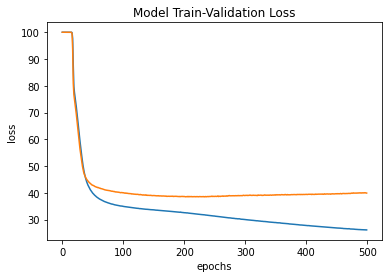

In [54]:
K.clear_session()

# 모델 학습
model = xDeepFM(linear_feature_columns, dnn_feature_columns, 
                dnn_use_bn=True, task='regression')
model.compile(optimizer=optimizers.Adam(lr=0.001), loss='mape')
# model.compile(optimizers.RMSprop(learning_rate=0.001), loss='mape')

# 모델 훈련
hist = model.fit(X_train, y_train,
                 batch_size=256,
                 epochs=500,
                 verbose=1,
                 validation_split=0.2)

plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Model Train-Validation Loss')
plt.show()

# 예측

 Train, Validation Loss는 괜찮은데 test data에 대해서는 별로 좋지 않은 듯하다. 튜닝 필요함.

In [55]:
# 평가지표 산식
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [56]:
# 예측
y_pred = model.predict(X_test)
y_pred

array([[4.7781115e+06],
       [4.4174808e+07],
       [1.1236523e+08],
       ...,
       [2.4151838e+07],
       [3.9272852e+07],
       [8.8073816e+07]], dtype=float32)

In [57]:
# MAPE 계산
mean_absolute_percentage_error(y_pred.reshape(-1, ), y_test['AMT'])

123.11982975326086